In [1]:
import os
import glob
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from astropy.coordinates import SkyCoord

from redrock import templates
from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read VI table
fvi = os.path.join('/global/cfs/cdirs/desi/sv/vi/TruthTables/', 'truth_table_BGS_full_66003.txt')#'truth_table_BGS_v1.1.csv')

vi_id, zrr_vi, ztrue, qa_flag, dchi2_vi, zwarn_vi, rflux_vi, vi_ra, vi_dec = np.genfromtxt(fvi, delimiter=',', skip_header=1, unpack=True, usecols=[1, 2, 4, 6, 11, 12, 16, -2, -1])# usecols=[0, 1, 2, 3, 10, 11, 15])
vi_id = vi_id.astype(int)

vi_coord = SkyCoord(ra=vi_ra*u.degree, dec=vi_dec*u.degree)

In [4]:
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [5]:
# exposures of VI tile
expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])

--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
  60 of 2241 have QA flag < 2.5
  84 of 2241 have delta z/(1+z) > 0.003
--- 55655 ---
  2241 of 5000 BGS targets have matches to VI
  60 of 2241 have QA flag < 2.5
  74 of 2241 have delta z/(1+z) > 0.003
--- 55656 ---
  2241 of 5000 BGS targets have matches to VI
  60 of 2241 have QA flag < 2.5
  120 of 2241 have delta z/(1+z) > 0.003


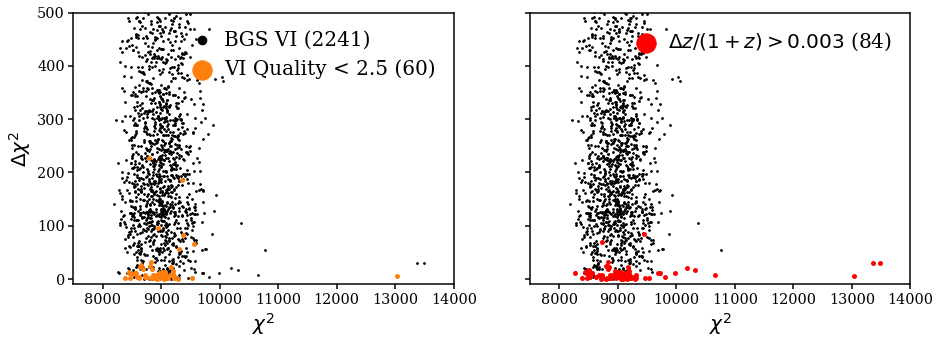

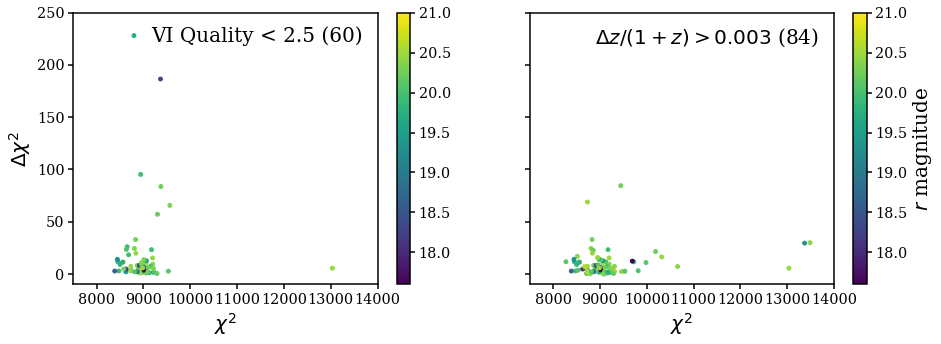

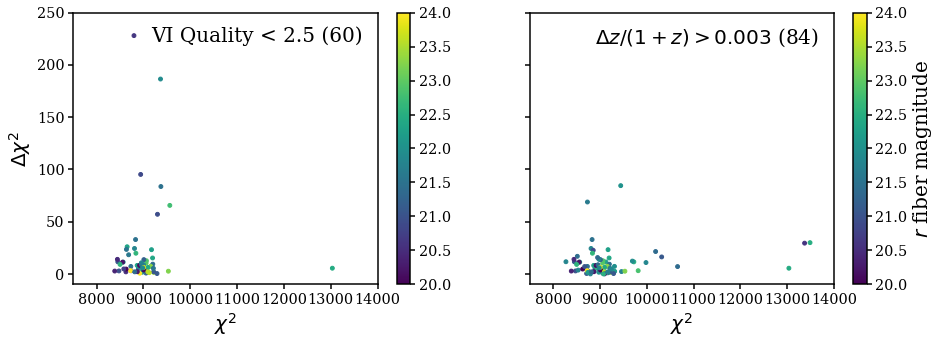

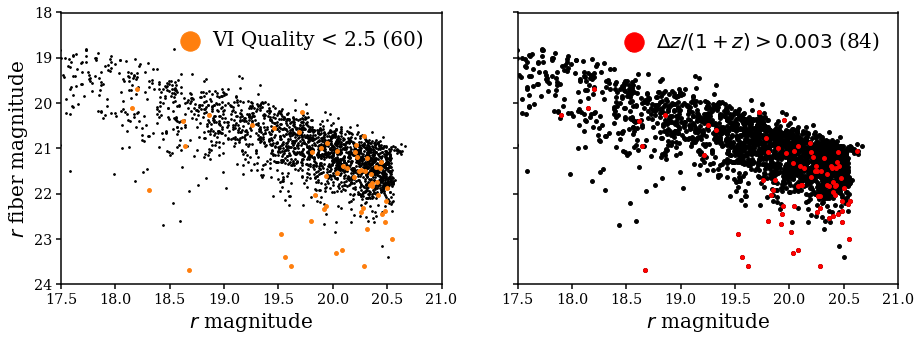

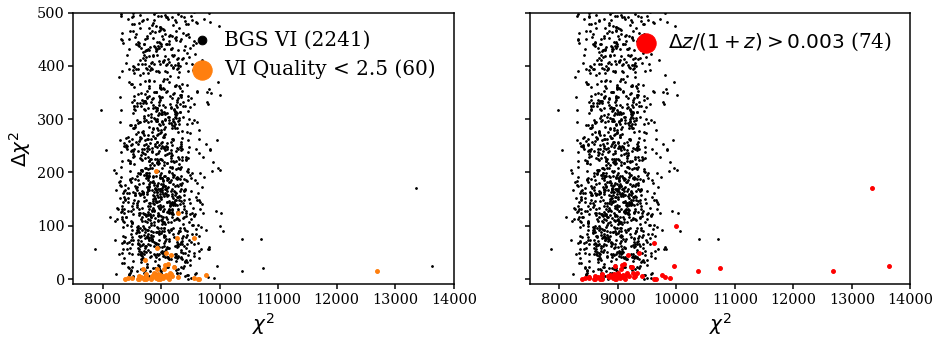

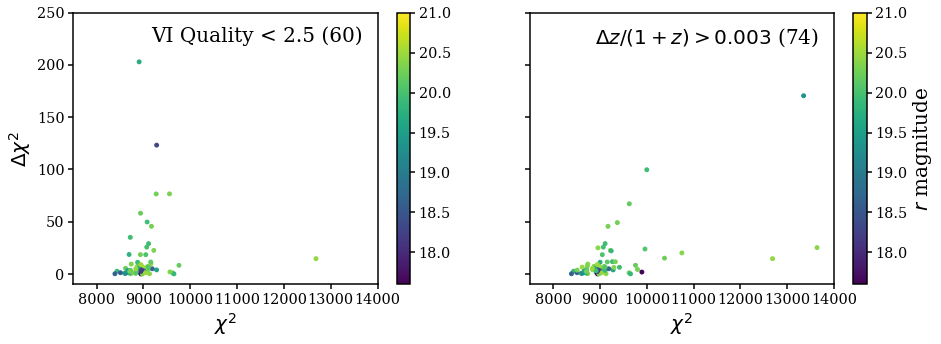

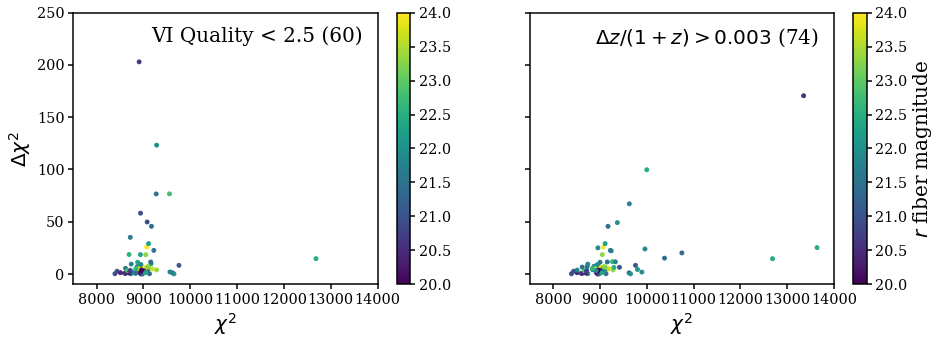

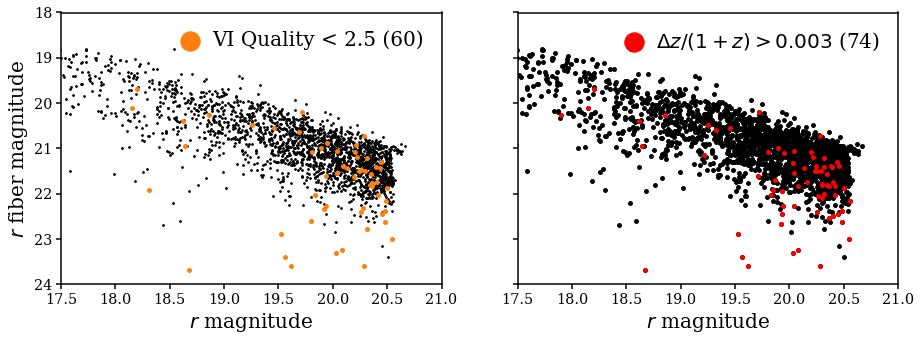

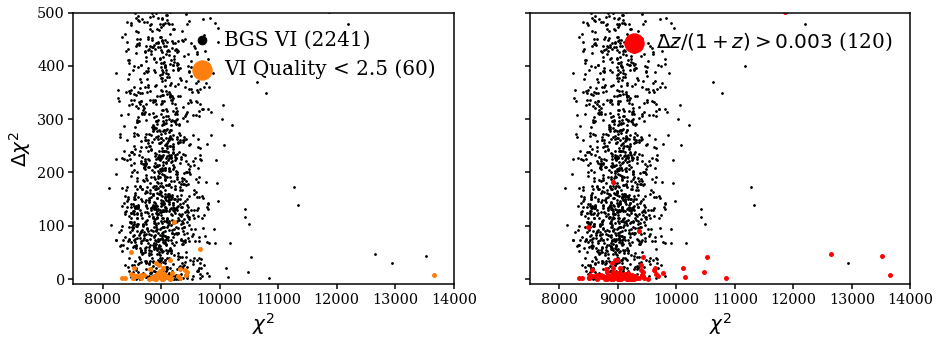

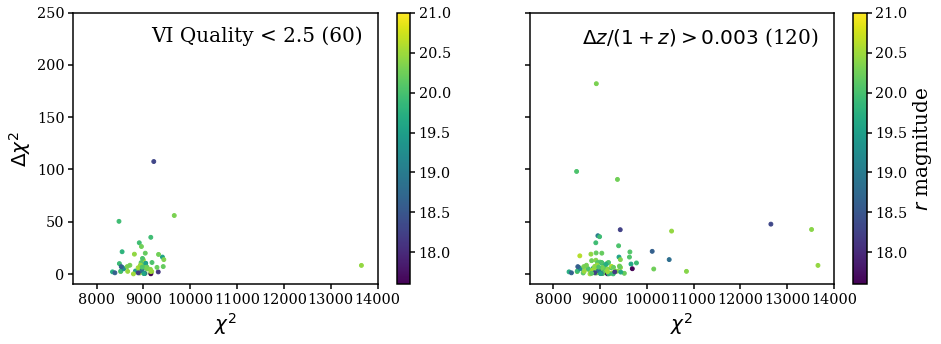

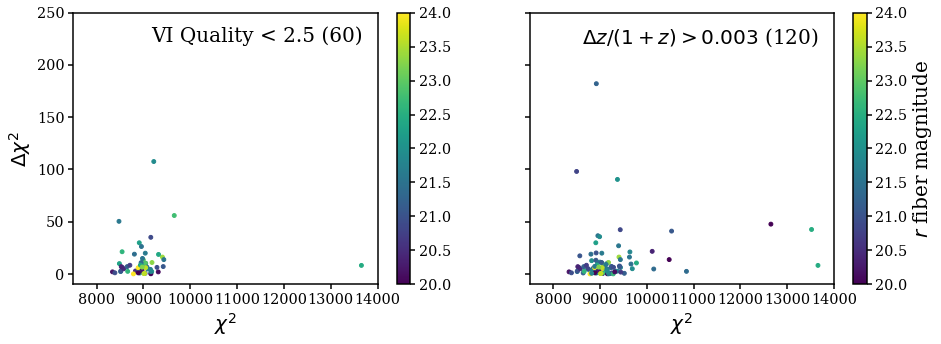

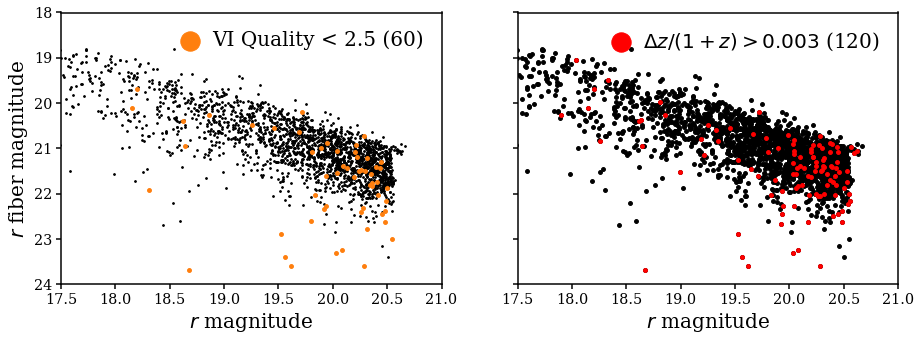

In [10]:
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_bgs, n_match = 0, 0
    ra, dec, rmags, rfibs, z_rrs, zwarns, chi2s, dchi2s = [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        ra.append(coadd['TARGET_RA'])
        dec.append(coadd['TARGET_DEC'])
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
        
    # match VI targets to coadd targets using RA and DEC because there
    # seems to be a bug in the TARGETIDs
    ra = np.concatenate(ra)
    dec = np.concatenate(dec)
    
    coadd_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    _m_coadd, _d, _ = vi_coord.match_to_catalog_sky(coadd_coord)
    m_vi = (_d.to(u.deg).value < 1e-5)
    m_coadd = _m_coadd[m_vi]
    assert np.sum(_d.to(u.deg).value > 1e-5) == 0
    print('  %i of %i BGS targets have matches to VI' % (np.sum(m_vi), n_bgs))

    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
        
    bad_vi = (qa_flag < 2.5)
    print('  %i of %i have QA flag < 2.5' % (np.sum(bad_vi), len(bad_vi)))
    
    rr_mismatch = np.abs(z_rrs - ztrue)/(1.+ztrue) > 0.003
    print('  %i of %i have delta z/(1+z) > 0.003' % (np.sum(rr_mismatch), len(rr_mismatch)))
    
    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(121)
    sub.scatter(chi2s, dchi2s, s=3, c='k', label='BGS VI (%i)' % len(bad_vi))
    sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_ylim(-10, 500)
    
    sub = fig.add_subplot(122)
    sub.scatter(chi2s, dchi2s, s=3, c='k')
    sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylim(-10, 500)
    sub.set_yticklabels([])

    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(121)
    _plt = sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c=rmags[bad_vi], s=15, vmin=17.6, vmax=21.)
    cbar = fig.colorbar(_plt, ax=sub)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_ylim(-10, 250)
    sub.text(0.95, 0.95, 'VI Quality < 2.5 (%i)' % np.sum(bad_vi), transform=sub.transAxes, ha='right', va='top', fontsize=20)
    
    sub = fig.add_subplot(122)
    _plt = sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c=rmags[rr_mismatch], vmin=17.6, vmax=21.)
    cbar = fig.colorbar(_plt, ax=sub)
    cbar.set_label('$r$ magnitude', fontsize=20)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylim(-10, 250)
    sub.set_yticklabels([])    
    sub.text(0.95, 0.95, '$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch), transform=sub.transAxes, ha='right', va='top', fontsize=20)
    
    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(121)
    _plt = sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c=rfibs[bad_vi], s=15, vmin=20., vmax=24.)
    cbar = fig.colorbar(_plt, ax=sub)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_ylim(-10, 250)
    sub.text(0.95, 0.95, 'VI Quality < 2.5 (%i)' % np.sum(bad_vi), transform=sub.transAxes, ha='right', va='top', fontsize=20)
    
    sub = fig.add_subplot(122)
    _plt = sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c=rfibs[rr_mismatch], vmin=20., vmax=24.)
    cbar = fig.colorbar(_plt, ax=sub)    
    cbar.set_label('$r$ fiber magnitude', fontsize=20)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylim(-10, 250)
    sub.set_yticklabels([])    
    sub.text(0.95, 0.95, '$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch), transform=sub.transAxes, ha='right', va='top', fontsize=20)
    
    
    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(121)
    sub.scatter(rmags, rfibs, c='k', s=3)
    sub.scatter(rmags[bad_vi], rfibs[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)    
    sub.set_xlabel(r'$r$ magnitude', fontsize=20)
    sub.set_xlim(17.5, 21)
    sub.set_ylabel(r'$r$ fiber magnitude', fontsize=20)
    sub.set_ylim(24., 18)    
    sub = fig.add_subplot(122)
    sub.scatter(rmags, rfibs, s=15, c='k')    
    sub.scatter(rmags[rr_mismatch], rfibs[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$r$ magnitude', fontsize=20)
    sub.set_xlim(17.5, 21)
    sub.set_ylim(24., 18)
    sub.set_yticklabels([])    